# Data Science / Machine Learning Meetup #1 Deep Learning Hands-on
# オルタナティブ・データと自然言語処理

## 演習概略

1. [前処理](#前処理)
1. [モデル構築](#モデル構築)
1. [予測](#予測)


## 環境準備

### パッケージのインストールとインポート

パッケージをインストールします（この処理は、プロジェクトで一度行えばよく、後から再度このファイルを使って分析する際にはスキップできます）

In [2]:
!pip3 install nltk==3.4.5
!pip3 install torch==1.4.0

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


上でインストールしたパッケージを含め、必要なモジュールをインポートします。

In [3]:
import json
import os
import random
import re
import subprocess
import glob
import traceback
from datetime import datetime

import sys

from operator import add
from pyspark.sql import SparkSession

import torch
import nltk
from torch import nn, optim
import torch.nn.functional as F

テーブルまたはリストのデータを表形式で表示するための、関数を定義します。

In [27]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

def show_plot(list, head_count=10):

    df_s = pd.DataFrame(list)
    df_s = df_s.head(head_count)

    fig,ax = plt.subplots(figsize=((len(df_s.columns)+1)*1.2, (len(df_s)+1)*0.4))
    ax.axis('off')
    tbl = ax.table(cellText=df_s.values,
                   bbox=[0,0,1,1],
                   colLabels=df_s.columns,
                   rowLabels=df_s.index)
    # plt.savefig('table.png') #PNG画像出力
    plt.show() 

### ファイルの確認

本ワークショップでは、事前に準備してあるトレーニング・データを用いて、感情分析のためのモデル構築を実施します。

クラスターのtmpディレクトリにあるファイルを自分のプロジェクト環境にコピーします。

In [10]:
!mv output.json output.json.pre

In [11]:
!export HADOOP_CONF_DIR=/etc/hadoop/conf; hdfs dfs -get /tmp/output.json .

In [12]:
!ls -l | grep output.json

-rw-r--r-- 1 cdsw cdsw 406480347 Feb 14 02:47 output.json
-rwx------ 1 cdsw cdsw 115763447 Feb 12 08:35 output.json.pre


In [13]:
!head output.json
!tail output.json

{"data":[{"message_body":"It’s ‘Star Trek’ vs. ‘Star Wars’ in European Streaming Battle  $CMCSA $VIAC $AAPL $AMZN $DIS ","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"$JD $AAPL","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10 from $YUMA","sentiment":0},
{"message_body":"pretty soon 2:10

## 前処理


### データの確認
データがどのように見えるかを確認します。

下記のような内容になっているはずです。
```
[{'message_body': '............................', 'sentiment': 2}, {'message_body': '............................', 'sentiment': -2}, ...}
```

In [15]:
with open('./output.json', 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': 'It’s ‘Star Trek’ vs. ‘Star Wars’ in European Streaming Battle  $CMCSA $VIAC $AAPL $AMZN $DIS ', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}, {'message_body': '$JD $AAPL', 'sentiment': 0}]


データ件数の確認

In [16]:
print(len(twits['data']))

2507901


In [17]:
positive_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == 2]

In [18]:
print(positive_messages[:10])

['$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow', '$AAPL Repo 8AM tomorrow']


In [19]:
negative_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == -2]

In [20]:
print(negative_messages[:10])

['$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open', '$AAPL bought 320 puts at the hod should open nicely looking for 70-80%+ at open']


### メッセージ本文とセンチメント・ラベルのリスト化
ニューラルネットワークで利用するために、-2 ~ 2 を取るセンチメント・スコアを 0 ~ 4 に変換します。

In [21]:
messages = [twit['message_body'] for twit in twits['data']]
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

### データの前処理

テキストを前処理します。

### プリプロセス関数の定義

In [22]:
nltk.download('wordnet')

def preprocess(message):
    """
    入力として文字列を受け取り、次の操作を実行する: 
        - 全てのアルファベットを小文字に変換
        - URLを削除
        - ティッカーシンボル($WWW)を削除
        - ユーザ名(@WWW)を削除 
        - 句読点等、アルファベット以外を削除
        - 文字列をスペースで分割しトークン化
        - 動詞の時制や、名詞の複数形など文法的な情報（構文中での語の使い方）を抽象し、単語を一般化
        - シングル・キャラクターのトークンを削除
    
    パラメータ
    ----------
        message : 前処理の対象テキストメッセージ
        
    戻り値
    -------
        tokens: 前処理後のトークン配列
    """ 
    
    text = message.lower()
    
    text = re.sub("http(s)?://([\w\-]+\.)+[\w-]+(/[\w\- ./?%&=]*)?",' ', text)
    
    text = re.sub("\$[^ \t\n\r\f]+", ' ', text)
    
    text = re.sub("@[^ \t\n\r\f]+", ' ', text)

    text = re.sub("[^a-z]", ' ', text)
    
    tokens = text.split()

    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(w, pos='v') for w in tokens if len(w) > 1]
    
    return tokens

[nltk_data] Downloading package wordnet to /home/cdsw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### メッセージ前処理
上記で定義した`preprocess`関数を全てStockTwitメッセージ・データに適用します。

※この処理には、データのサイズに応じて多少時間がかかります。

In [23]:
tokenized = list(map(preprocess, messages))

print(tokenized[:3])
print(len(tokenized))

[['it', 'star', 'trek', 'vs', 'star', 'war', 'in', 'european', 'stream', 'battle'], [], []]
2507901


### Bag of Words

すべてのメッセージがトークン化されたので、ボキャブラリ（語彙）データを作成します。
その際に、コーパス全体で各単語が出現する頻度をカウントします
（[`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter)関数を利用）。

※この処理には、データのサイズに応じて多少時間がかかります。

In [24]:
from collections import Counter

out_list = tokenized
words = [element for in_list in out_list for element in in_list]

word_counts = Counter(words)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
vocab_to_int = {word:ii for ii, word in int_to_vocab.items()}

bow = []
for tokens in tokenized:
    bow.append([vocab_to_int[token] for token in tokens])

print(len(bow))

2507901


### 単語の重要性（メッセージに現れる頻度）に応じた調整

ボキャブラリーを使用して、「the」、「and」、「it」などの最も一般的な単語の一部を削除します。
これらの単語は非常に一般的であるため、センチメントを特定する目的に寄与せず、ニューラルネットワークへの入力のノイズとなります。これらを除外することで、ネットワークの学習時間を短縮することができます。

また、非常に稀にしか用いられない単語も削除します。
ここでは、各単語のカウントをメッセージの数で除算する必要があります。

次に、メッセージのごく一部にしか表示されない単語を削除します。

In [25]:
print("len(sorted_vocab):",len(sorted_vocab))
print("sorted_vocab - top:", sorted_vocab[:3])
print("sorted_vocab - least:", sorted_vocab[-15:])

total_count = len(words)
freqs = {word: count/total_count for word, count in word_counts.items()}

print("freqs[the]:",freqs["the"] )

low_cutoff = 0.000002
high_cutoff = 20
print("high_cutoff:",high_cutoff)
print("low_cutoff:",low_cutoff)

K_most_common = sorted_vocab[:high_cutoff]

print("K_most_common:",K_most_common)

filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]

print("len(filtered_words):",len(filtered_words)) 

len(sorted_vocab): 6824
sorted_vocab - top: ['utm', 'the', 'amp']
sorted_vocab - least: ['viab', 'ppg', 'ipg', 'null', 'marketbea', 'slump', 'aevi', 'leggett', 'platt', 'newmont', 'geologist', 'specialization', 'fossil', 'deposit', 'laughable']
freqs[the]: 0.024782663006321058
high_cutoff: 20
low_cutoff: 2e-06
K_most_common: ['utm', 'the', 'amp', 'of', 'be', 'to', 'file', 'on', 'and', 'in', 'form', 'for', 'medium', 'campaign', 'report', 'have', 'share', 'social', 'just', 'ownership']
len(filtered_words): 6804


##  データ探索

### 一般的な単語

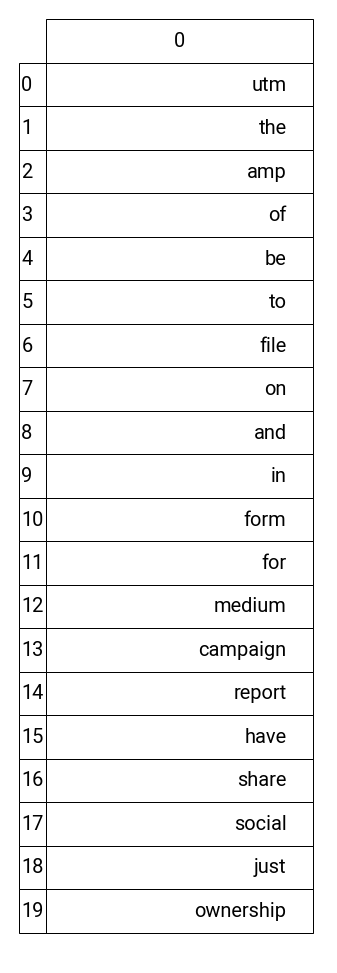

In [28]:
show_plot(K_most_common, head_count=20)

### センチメント毎の頻出単語

In [29]:
def convert_to_sorted_vocab(messages):
    words = [word for message in messages for word in message]

    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)

    return sorted_vocab

In [30]:
def filter_words(sorted_vocab, freqs):

    low_cutoff = 0.000002

    high_cutoff = 20

    K_most_common = sorted_vocab[:high_cutoff]

    filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
    
    return filtered_words

In [31]:
negative_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == -2]
negative_tokenized = list(map(preprocess, negative_messages))
negative_sorted_vocab = convert_to_sorted_vocab(negative_tokenized)

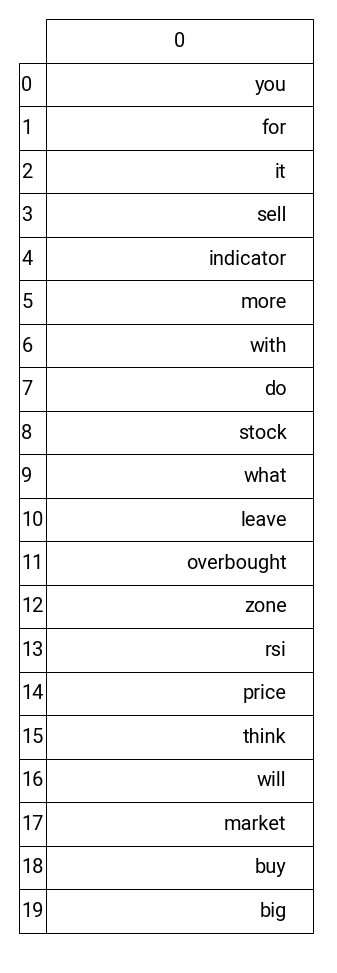

In [32]:
show_plot(negative_sorted_vocab[20:], head_count=20)

In [33]:
positive_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == 2]
positive_tokenized = list(map(preprocess, positive_messages))
positive_sorted_vocab = convert_to_sorted_vocab(positive_tokenized)

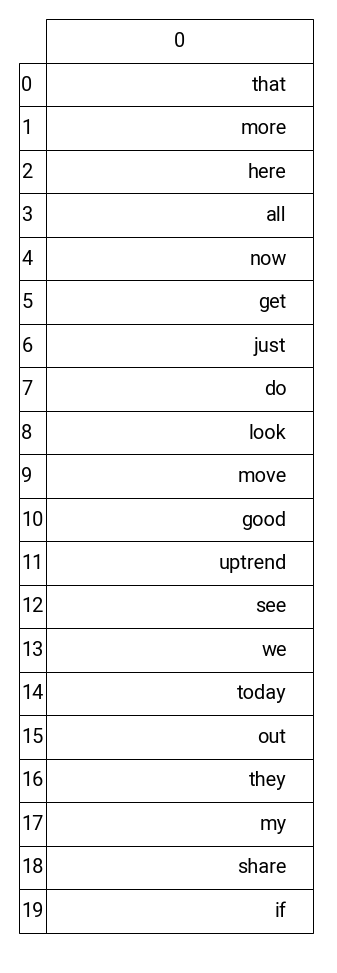

In [34]:
show_plot(positive_sorted_vocab[20:], head_count=20)

### フィルターされた単語を削除して語彙辞書を更新

In [35]:
vocab =  {word:ii for ii, word in enumerate(filtered_words)}

id2vocab = {ii:word for word, ii in vocab.items()}

print("len(tokenized):", len(tokenized))

filtered = [[token for token in tokens if token in vocab] for tokens in tokenized]

print("len(filtered):", len(filtered))
print("tokenized[:1]", tokenized[:1])
print("filtered[:1]",filtered[:1])

len(tokenized): 2507901
len(filtered): 2507901
tokenized[:1] [['it', 'star', 'trek', 'vs', 'star', 'war', 'in', 'european', 'stream', 'battle']]
filtered[:1] [['it', 'star', 'trek', 'vs', 'star', 'war', 'european', 'stream', 'battle']]


### 分類クラス間のバランス

訓練データのラベルには、一般に偏りがあることがよく見受けられます（例外的なデータは少ない）。
例えば、データの50％がニュートラルであること場合、毎回0（ニュートラル）を予測するだけで、ネットワークの精度が50％になることを意味します。

ネットワークが適切に学習できるように、クラスのバランスを取る必要があります。つまり、それぞれのセンチメントスコアがデータにほぼ同じ頻度で表含まれていることが望ましいと言えます。

ここでは、中立的な感情を持つデータを全体の20%になるように、ランダムにドロップします。

データに含まれるニュートラルデータのパーセンテージと、データ削除により期待されるパーセンテージの値を使って、
データをドロップする確率を求めます。

同時に、長さが0のメッセージを削除します。

In [36]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)

keep_prob = (N_examples - n_neutral)/4/n_neutral

print("keep prob:", keep_prob)

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

keep prob: 0.059556107654731086


バランスされたデータ中、センチメントが「ニュートラル」であるデータの割合を確認します。

In [37]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.212212254032031

ボキャブラリ・ファイルを保存します。このファイルは、予測の際に、入力を変換するために必要になります。

In [13]:
import pickle

with open('vocab.pickle', 'wb') as f:
    pickle.dump(vocab, f)

## モデルの構築

これでボキャブラリーができたので、トークンをIDに変換し、それをネットワークに渡すことができます。ネットワークを定義します


### SentimentClassifier (感情分類器)実装

クラスは、3つの主要な部分で構成されています：: 

1. init function `__init__` 
2. forward pass `forward`  
3. hidden state `init_hidden`. 

In [38]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, self.lstm_size, self.lstm_layers, dropout=self.dropout)
        
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)


    def init_hidden(self, batch_size):
        
        # 隠れ層として、n_layers x batch_size x hidden_dimの構造を持つテンソルを二つ作成し、ゼロで初期化        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.lstm_layers, batch_size,self.lstm_size).zero_(),
                         weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        return hidden


    def forward(self, nn_input, hidden_state):
        
        batch_size = nn_input.size(0)
        
        # embed
        embeds = self.embedding(nn_input)
        
        # LSTM
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)

        lstm_out = lstm_out[-1,:,:]
        
        # dropout
        out = self.dropout(lstm_out)
        
        # Dense Layer (nn.Linear) RNNの隠れ層から値を予測
        out = self.fc(out)
        
        # Softmax関数
        logps = self.softmax(out)
        
        
        return logps, hidden_state

### モデルの確認

In [39]:
model = SentimentClassifier(len(vocab), 10, 6, 5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
batch_size = 4
hidden = model.init_hidden(4)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.5204, -1.9271, -2.0425, -1.4964, -1.2653],
        [-1.5090, -1.9343, -2.0199, -1.4861, -1.2894],
        [-1.5016, -1.9469, -2.0478, -1.4724, -1.2869],
        [-1.5272, -1.9128, -2.0274, -1.4807, -1.2873]],
       grad_fn=<LogSoftmaxBackward>)


### DataLoader定義

データをバッチとして渡す関数を定義します。

ネットワークへの入力は次のような形になります：(sequence_length, batch_size)

したがって、シーケンス（メッセージデータ）が40トークンで、25シーケンスを渡す場合、入力サイズは(40, 25)になります。

シーケンスの長さを40に設定した場合、40トークンより多いまたは少ないメッセージは、以下のように処理します。
- 40トークン未満のメッセージの場合、足りない部分は先頭からゼロを埋め込む。
   - データを処理する前にRNNが何も開始しないように、先頭にを空欄を配置します。
   - メッセージに20個のトークンがある場合、最初の20個のスポットは0になる。
- メッセージに40個を超えるトークンがある場合、最初の40個のトークンを保持。

In [40]:
def dataloader(messages, labels, sequence_length=20, batch_size=32, shuffle=False):
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # ゼロで初期化
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # レフトパッド
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### トークンIDの作成

トレーニングに用いるメッセージに含まれる単語を、辞書を使ってID（数値）に変換します。この処理は、ニューラルネットワークの入力として用いるために必要です。

In [41]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

In [42]:
print(token_ids[:10])

[[8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9], [8, 9]]


###  データの分割（訓練用と検証用）

In [43]:
split_frac = 0.98 # for small data
#split_frac = 0.8 # for big data

split_idx = int(len(token_ids)*split_frac)
train_features, remaining_features = token_ids[:split_idx], token_ids[split_idx:]
train_labels, remaining_labels = sentiments[:split_idx], sentiments[split_idx:]

test_idx = int(len(remaining_features)*0.5)
valid_features, test_features = remaining_features[:test_idx], remaining_features[test_idx:]
valid_labels, test_labels = remaining_labels[:test_idx], remaining_labels[test_idx:]

### トレーニング

#### トレーニング準備

利用可能なデバイス(CUDA/GPUまたはGPU)を確認します。

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
#model = SentimentClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
model = SentimentClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

SentimentClassifier(
  (embedding): Embedding(6805, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): LogSoftmax()
)

#### トレーニング実施

トレーニングを実行します。モデルの訓練の進行度合を確認するために、定期的にLossを出力します。

※この処理には、データのサイズに応じて、十分な時間が必要です。

GPUを備えた環境で実行する場合、ターミナルで以下のコマンドを実行することで、GPUが利用されていることを確認することができます（ GPU実行中、コマンド実行により表示されるテーブルの右上のVolatile GPU-Utilのパーセンテージ値が増えます）
```
$ watch nvidia-smi
```

In [46]:
import numpy as np

epochs = 5
batch_size =  64
batch_size =  512
learning_rate = 0.001

print_every = 100
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

#val_losses = []
total_losses = []
#accuracy = []

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    
    steps = 0
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        steps += 1
        hidden = model.init_hidden(labels.shape[0]) 
        
        # デバイス(CPU, GPU)の設定
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # モデルのトレーニング
        hidden = tuple([each.data for each in hidden])
        model.zero_grad()
        output, hidden = model(text_batch, hidden)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        clip = 5
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Accumulate loss
        #val_losses.append(loss.item())
        total_losses.append(loss.item())
        
        correct_count = 0.0
        if steps % print_every == 0:
            model.eval()
            
            # Calculate accuracy
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            #?top_class = top_class.to(device)
            #?labels = labels.to(device)

            correct_count += torch.sum(top_class.squeeze()== labels)
            #accuracy.append(100*correct_count/len(labels))
            
            # Print metrics
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                 "Step: {}...".format(steps),
                 "Loss: {:.6f}...".format(loss.item()),
                 "Total Loss: {:.6f}".format(np.mean(total_losses)),
                 #"Collect Count: {}".format(correct_count),
                 #"Accuracy: {:.2f}".format((100*correct_count/len(labels))),
                 # AttributeError: 'torch.dtype' object has no attribute 'type'
                 #"Accuracy Avg: {:.2f}".format(np.mean(accuracy))
                 )
            
            model.train()

Starting epoch 1


KeyboardInterrupt: 

In [21]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

## 予測

### Prediction関数の作成

訓練されたモデルを使って、入力されたテキストから予測結果を生成するpredict関数を実装します。

テキストは、ネットワークに渡される前に前処理される必要があります。

In [22]:
import glob
import pickle
import re
import nltk
import numpy as np
import os
import sys

import torch

nltk.download('wordnet')

cur_dir = os.path.dirname(os.path.abspath('__file__'))
print(cur_dir)
sys.path.append(cur_dir)

vocab_filename = 'vocab.pickle'
vocab_path = cur_dir + "/" + vocab_filename
vocab_l = pickle.load(open(vocab_path, 'rb'))

#model_path = cur_dir + "/" + "model.torch"
#model_l = torch.load(model_path, map_location='cpu')

model_l = SentimentClassifier(len(vocab_l)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
checkpoint = torch.load('./checkpoint.pth.tar')
model_l.load_state_dict(checkpoint['state_dict'])

class UnknownWordsError(Exception):
    "Only unknown words are included in text"


def predict_func(text, model, vocab):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.
    Returns
    -------
        pred : 予測値（numpyベクトル）
    """

    tokens = preprocess(text)    

    # Filter non-vocab words
    tokens = [token for token in tokens if token in vocab] #pass
    # Convert words to ids
    tokens = [vocab[token] for token in tokens] #pass

    if len(tokens) == 0:
        raise UnknownWordsError

    # Adding a batch dimension
    text_input = torch.from_numpy(np.asarray(torch.LongTensor(tokens).view(-1, 1)))

    # Get the NN output       
    batch_size = 1
    hidden = model.init_hidden(batch_size) #pass
    
    logps, _ = model(text_input, hidden) #pass
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.round(logps.squeeze())#pass
    pred = torch.exp(logps) 
    
    return pred


def predict_api(args):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        args : 入力（Pythonディクショナリ）
    Returns
    -------
        pred : 予測値（Python配列）
    """
    text = args.get('text')
    try:
        result = predict_func(text, model_l, vocab_l)
        return result.detach().numpy()[0]
    except UnknownWordsError:
        return [0,0,1,0,0]

/home/cdsw


[nltk_data] Downloading package wordnet to /home/cdsw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ポジティブなセンチメントを連想させる文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [23]:
args = {"text": "I'm bullish on $goog"}
result = predict_api(args)
print(result)

[ 0.02395445  0.02243885  0.03738181  0.02565586  0.89056903]


ネガティブなセンチメントを連想させる文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [24]:
args = {"text": "I'm bearish on $goog"}
result = predict_api(args)
print(result)

[ 0.76727909  0.07537365  0.05268526  0.08244011  0.02222182]


ボキャブラリ辞書に存在しない単語のみの文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [25]:
args = {"text": "kono yoshiyuki"}
result = predict_api(args)
print(result)

[0, 0, 1, 0, 0]
